# WoW Classic Druid Feral Tank Attack Speed Analysis by Zidnae

## A Quantitative Look at the Effect of Attack Speed Buffs on Feral Tanking in WoW Classic

The base druid attack speed in bear form is 2.5. Throughout the game there are a number of items and buffs that increase attack speed. We can calculate the cumulative effect of these attack speed buffs using the following [formula](https://classic-wow.fandom.com/wiki/Attack_speed)

```
Attack_speed = "current attack speed" / (("Percent increase or decrease" / 100) + 1 )
```

Available items/effects that increase attack speed are:

| Item   |      Attack Speed Increase      |  Type |
|----------|-------------|--------|
| [Iron Counterweight](https://classic.wowhead.com/item=6043/iron-counterweight) |  3% | weapon enchant |
| [Libram of Rapidity](https://classic.wowhead.com/quest=7483/libram-of-rapidity) |    1% | head/leg enchant   |  
| [Manual Crowd Pummeler](https://classic.wowhead.com/item=9449/manual-crowd-pummeler) | 50%| on-use effect |
| [Kiss of the Spider](https://classic.wowhead.com/item=22954/kiss-of-the-spider) | 20% |on-use trinket |
| [Warchief's Blessing](https://classic.wowhead.com/spell=16609/warchiefs-blessing) | 15%| world buff |
| [Enchant Gloves Minor Haste](https://classic.wowhead.com/spell=13948/enchant-gloves-minor-haste) | 1% | glove enchant |
| [Gnomish Battle Chicken](https://classic.wowhead.com/spell=12906/gnomish-battle-chicken) | 5% | "Battle Squak" buff occasionally given by engineering pet to party |

There's also the JuJu Flurry buff but it's not included here since the effect was [bugged in Vanilla](https://eu.forums.blizzard.com/en/wow/t/juju-flurry-buff-%E2%80%93-not-a-bug/117855) and the bug was replicated in Classic. Also the Battle Chicken buff will be omitted from the analysis below since it's difficult to consistently get the effect to proc. 


Common combinations of the above attack speed items yield attack speeds (according to [WowWiki](https://classic-wow.fandom.com/wiki/Attack_speed) attack speed values get rounded to 4 significant digits)

In [1]:
ic = 1.03
libram = 1.01
mcp = 1.50
kots = 1.20
wcb = 1.15
ecmh = 1.01

attackSpeedCombinations = {
    "Base Attack Speed" : 2.5,
    "Iron Counterweight + Librams + Glove Enchant" : round(2.5 / (ic * libram * libram *ecmh),4),
    "Iron Counterweight + Librams + Glove Enchant + Warchief's Blessing" : round(2.5 / (ic * libram * libram *ecmh * wcb),4),
    "Manual Crowd Pummeler" : round(2.5 / (mcp),4),
    "Manual Crowd Pummeler + Librams + Glove Enchant" : round(2.5 / (mcp * libram * libram *ecmh),4),
    "Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant" : round(2.5 / (mcp * ic * libram * libram *ecmh),4),
    "Manual Crowd Pummeler + Librams + Glove Enchant + Warchief's Blessing" : round(2.5 / (mcp * libram * libram *ecmh *wcb),4),
    "Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Warchief's Blessing" : round(2.5 / (mcp * ic * libram * libram *ecmh *wcb),4),
    "Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Kiss of the Spider" : round(2.5 / (mcp * ic * libram * libram *ecmh *kots),4),
    "Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Kiss of the Spider + Warchief's Blessing" : round(2.5 / (mcp * ic * libram * libram *ecmh *kots * wcb),4)
}
allianceOnlyAttackSpeedCombinations = {k:v for k,v in attackSpeedCombinations.items() if "Warchief's Blessing" not in k}
attackSpeedCombinationsNoKiss = {k:v for k,v in attackSpeedCombinations.items() if "Kiss" not in k}
allianceOnlyAttackSpeedCombinationsNoKiss = {k:v for k,v in allianceOnlyAttackSpeedCombinations.items() if "Kiss" not in k}
table = "| Items   |      Attack Speed |\n|:---------|------------|\n"
for name, value in attackSpeedCombinations.items():
    table += f"| {name} | {value} |\n"

from IPython.display import display, Markdown, Latex
display(Markdown(table))

| Items   |      Attack Speed |
|:---------|------------|
| Base Attack Speed | 2.5 |
| Iron Counterweight + Librams + Glove Enchant | 2.3558 |
| Iron Counterweight + Librams + Glove Enchant + Warchief's Blessing | 2.0485 |
| Manual Crowd Pummeler | 1.6667 |
| Manual Crowd Pummeler + Librams + Glove Enchant | 1.6177 |
| Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant | 1.5705 |
| Manual Crowd Pummeler + Librams + Glove Enchant + Warchief's Blessing | 1.4067 |
| Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Warchief's Blessing | 1.3657 |
| Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Kiss of the Spider | 1.3088 |
| Manual Crowd Pummeler + Iron Counterweight + Librams + Glove Enchant + Kiss of the Spider + Warchief's Blessing | 1.1381 |


# Spell Batching 

An important aspect to consider when analyzing attack speed in classic is spell batching. Quoting directory from https://github.com/magey/classic-warrior/wiki/Spell-batching#auto-attacks

> ## Official statements from Blizzard
> Source: https://web.archive.org/web/20140619092137/us.battle.net/wow/en/forum/topic/13087818929?page=6#114
> > **Any action that one unit takes on another different unit used to be processed in batches every 400ms**. Some very attentive people may have noticed that healing yourself would give you the health instantly (minus client/server latency), whereas healing another unit would incur a delay of between 0ms and 400ms (again, on top of client/server latency). Same with damaging, applying auras, interrupting, knocking back, etc.
>
> Source: https://eu.forums.blizzard.com/en/wow/t/spell-batching-in-classic/39542
>
> > For WoW Classic, we’re moving spell casts to a low-priority loop that will cause them to be processed at the frequency that best fits how the game actually played in version 1.12. Two mages will be able to Polymorph each other somewhat reliably, resulting in two sheep 
nervously pacing around at range. Two warriors will be able to Charge one another, and the end result will be both warriors standing stunned in each other’s original location.
>
> ## Observations from the beta
> The key takeaway from Blizzard's statements regarding spell batching is "**Any action that one unit takes on another different unit used to be processed in batches every 400ms**". What does this mean in practice? first of all it means that any action that you take on yourself (healing yourself, buffing yourself, etc.) is instant; only actions taken on other units, be it players or mobs, are batched.
>
> It's important to note that only the application of damage or healing and buffs/debuffs resulting from an attack, cast or use of an ability are delayed until the next batch processing window; the calculations which determine if the attack hit or missed and if it triggered any procs happen **immediately** when the cast finishes, and the player can immediately start casting another spell or use another ability before the damage of the previous one has even been applied (you can find an example of this below involving Frostbolt).
>
>
> ### Auto attacks
When you're auto attacking a target the combat log will show you a `SWING_DAMAGE` message if you hit the target or a `SWING_MISSED` message if you missed or were avoided at the interval of your swing speed, i.e. if you're using a 3.6 speed weapon then these messages will show up every 3.6 seconds. But these messages are only one part of the equation; they signal when the attack table roll happens and damage calculations are performed but the actual damage of your auto attack is not applied to the target until the next batch is processed by the server. When this happens, and advanced combat logging is enabled in the client, the combat log will show a `SWING_DAMAGE_LANDED` message signaling the actual application of the damage on the target. Example (edited for brevity):
>
> ```
6/8 11:38:15.866  SWING_DAMAGE (Glance for 125)
6/8 11:38:15.967  SWING_DAMAGE_LANDED (Glance for 125)
6/8 11:38:19.480  SWING_DAMAGE (Glance for 107)
6/8 11:38:19.589  SWING_DAMAGE_LANDED (Glance for 107)
6/8 11:38:23.089  SWING_MISSED (Miss)
6/8 11:38:26.684  SWING_MISSED (Miss)
6/8 11:38:30.290  SWING_DAMAGE (Hit for 134)
6/8 11:38:30.528  SWING_DAMAGE_LANDED (Hit for 134)
6/8 11:38:33.887  SWING_MISSED (Parry)
6/8 11:38:37.409  SWING_DAMAGE (Crit for 258)
6/8 11:38:37.814  SWING_DAMAGE_LANDED (Crit for 258)
```
>
> If you look at the time difference between the different `SWING_DAMAGE` and `SWING_MISSED` messages you will see they align with a 3.6 weapon swing timer.



# Attack Speed Visualizations
Armed with this information we can now visualize the effects of the attack speed buffs on when our auto attacks land.

## Simplfying Assumptions
- The first attack lands precisely before the first spell batch
- All hits land and generate a constant amount of threat

In [2]:
import numpy as np
import matplotlib.pyplot as plt

SPELL_BATCH_INTERVAL = .400 #secs
THREAT_PER_HIT = 100

def computeThreat(attackTimes):
    threat = np.array(range(1,len(attackTimes)+1)) * THREAT_PER_HIT
    return threat

def computeAttackTimes(combatStartTime, attackSpeed, encounterTime):
    spellBatchTimes = np.arange(0, encounterTime*2, SPELL_BATCH_INTERVAL)
    attackTimesWithoutSpellBatch = np.arange(combatStartTime, encounterTime+5, attackSpeed)
    spellBatchedAttacks = []
    for attackTime in attackTimesWithoutSpellBatch:
        attackOnBatch = spellBatchTimes[spellBatchTimes >= attackTime][0]
        if attackOnBatch > encounterTime:
                spellBatchedAttacks.append(encounterTime)
                break
        spellBatchedAttacks.append(attackOnBatch)
    spellBatchedAttacks=np.array(spellBatchedAttacks)
    return spellBatchedAttacks

def generatePlot(attackSpeedCombos, encounterTime,combatStartTime=0):
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))

    fig = plt.figure(figsize=(50,8))
    ax = plt.gca()
    xticks = np.arange(0,encounterTime+SPELL_BATCH_INTERVAL,SPELL_BATCH_INTERVAL)
    while len(xticks) > 40/SPELL_BATCH_INTERVAL:
        xticks = xticks[::2]
    ax.set_xticks(xticks)
    for itemCombination, attackSpeed in attackSpeedCombos.items():
        attackTimes = computeAttackTimes(combatStartTime, attackSpeed, encounterTime)
        plt.step(
                 attackTimes,
                 computeThreat(attackTimes),
                 label=itemCombination
        )

    plt.grid(markevery=1,axis='x',which='both')
    plt.xlabel('Time (secs)')
    plt.ylabel('Potential Threat')
    plt.legend(title='Simplified Threat Ceiling:')
    plt.show()

# Alliance Attack Speed Results (i.e. no Warchief's Blessing)
- I am aware you can get mind controlled to get Warchief's Blessing as an Alliance player 
- Kiss of the Spider only lasts 15secs and is not included in the longer duration plots (I didn't feel like modeling a player's attack speed changing over the course of an encounter)

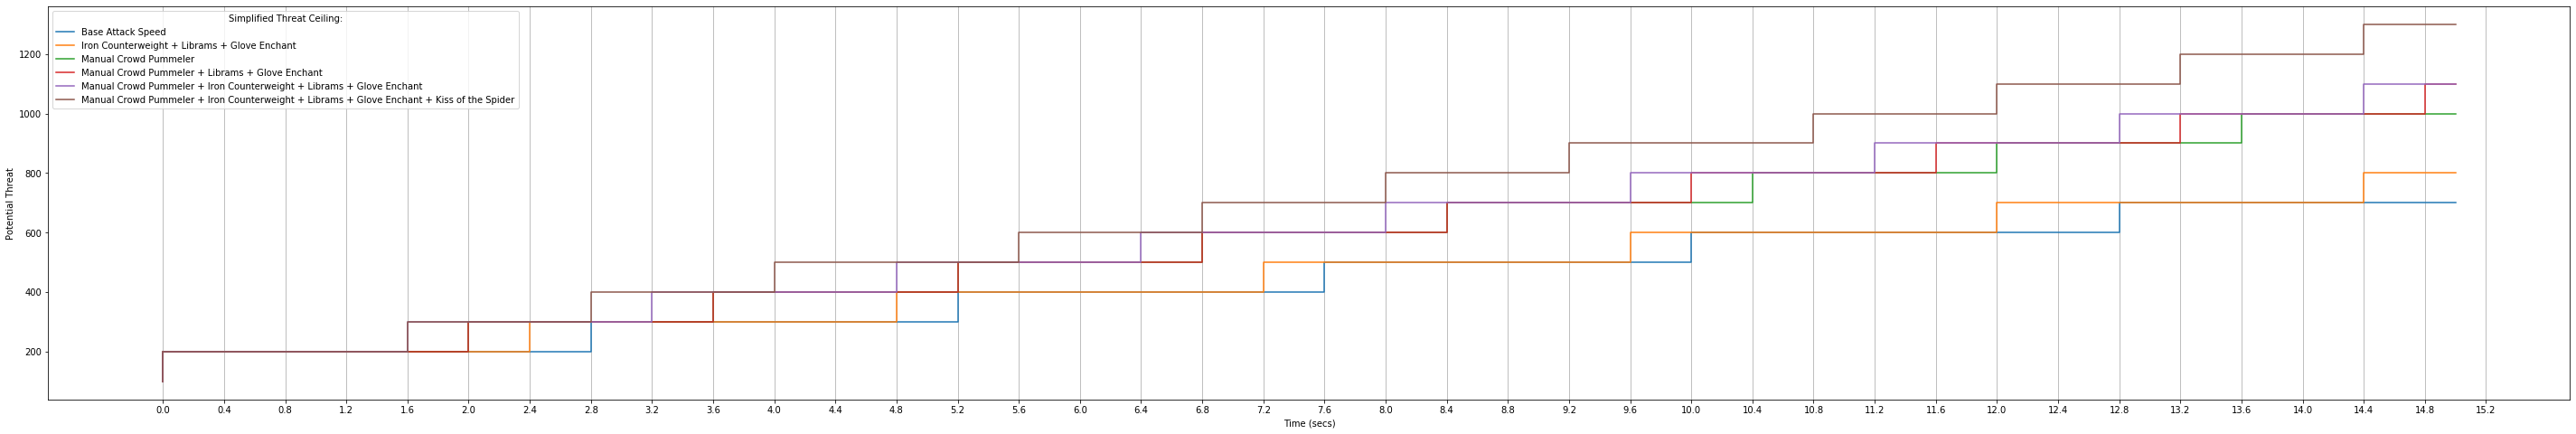

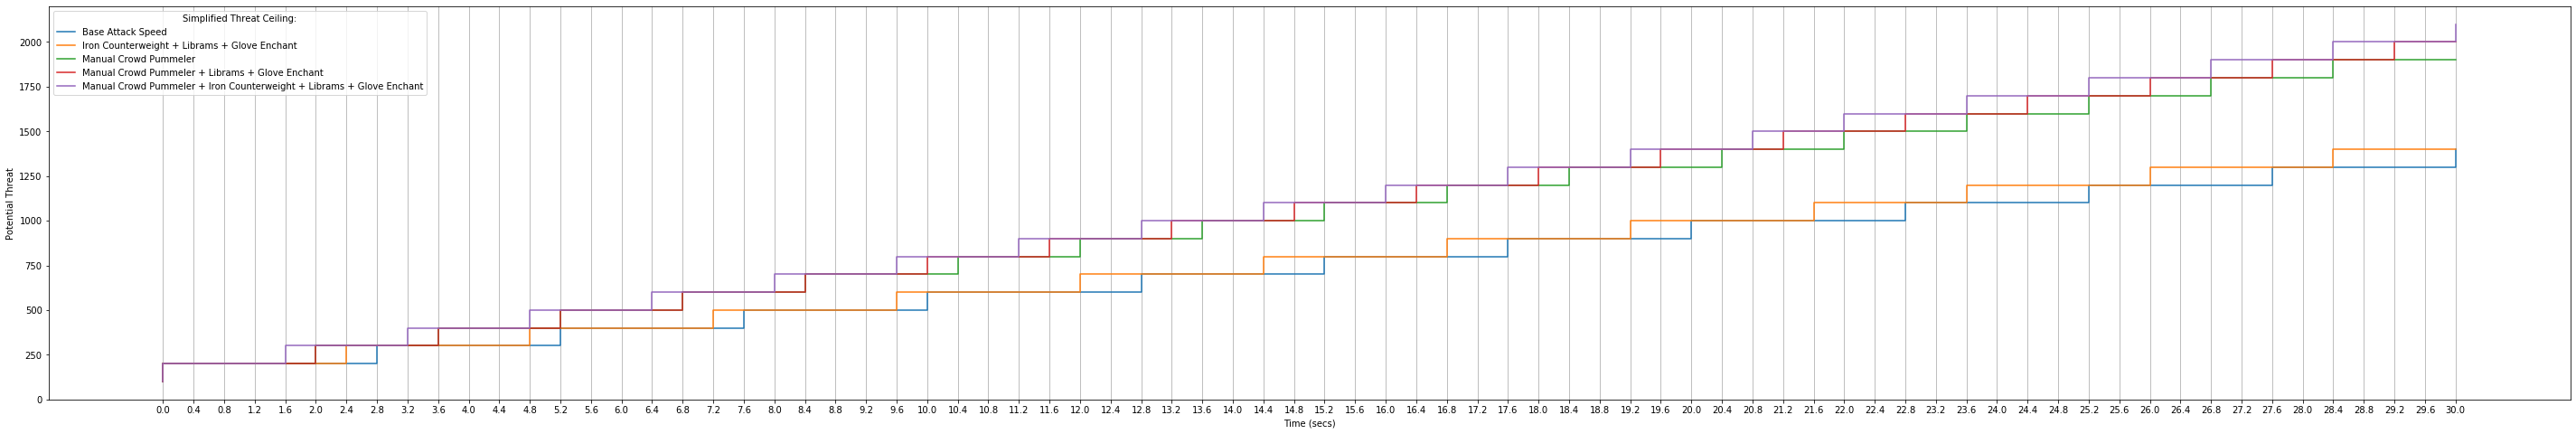

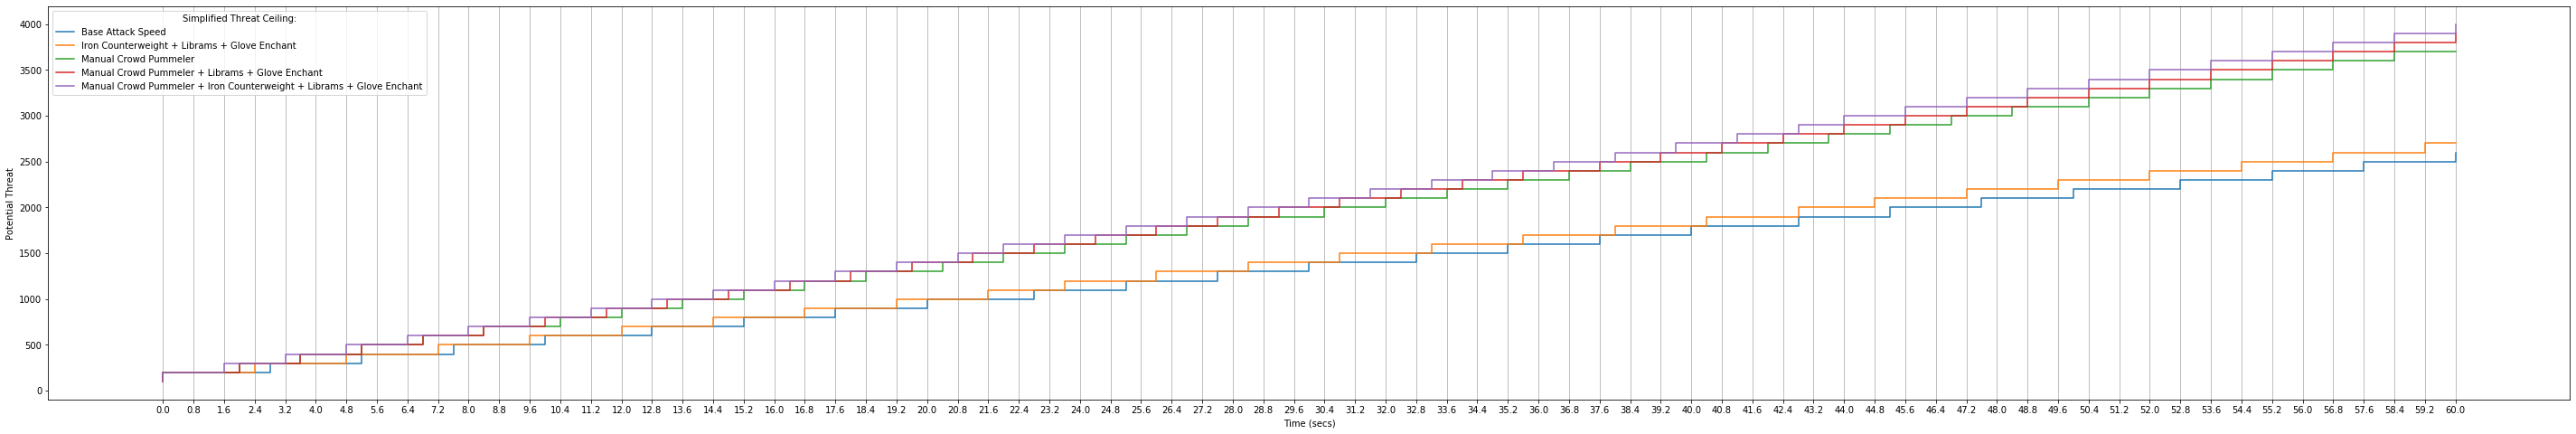

In [3]:
generatePlot(allianceOnlyAttackSpeedCombinations, 15)
generatePlot(allianceOnlyAttackSpeedCombinationsNoKiss, 30)
generatePlot(allianceOnlyAttackSpeedCombinationsNoKiss, 60)

# Horde Attack Speed Results

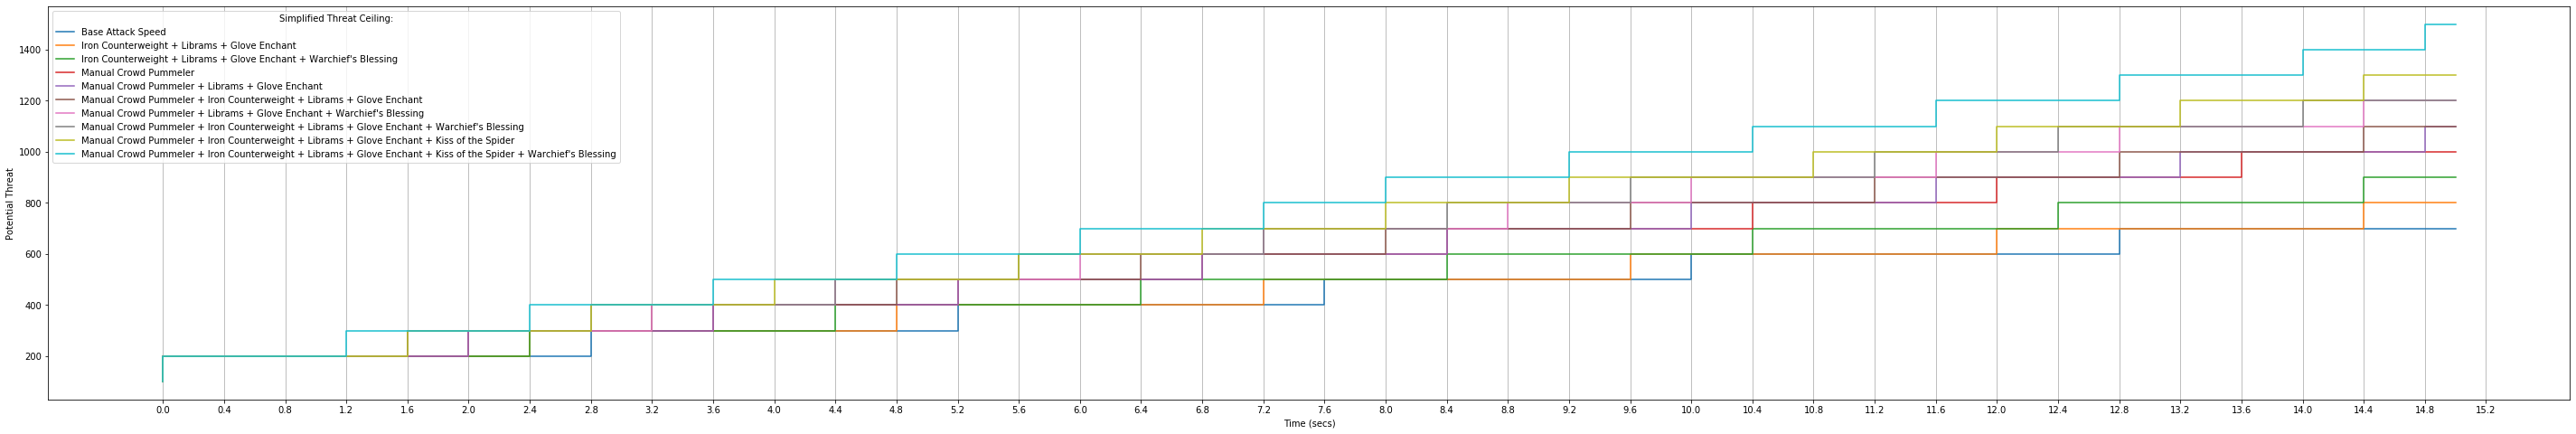

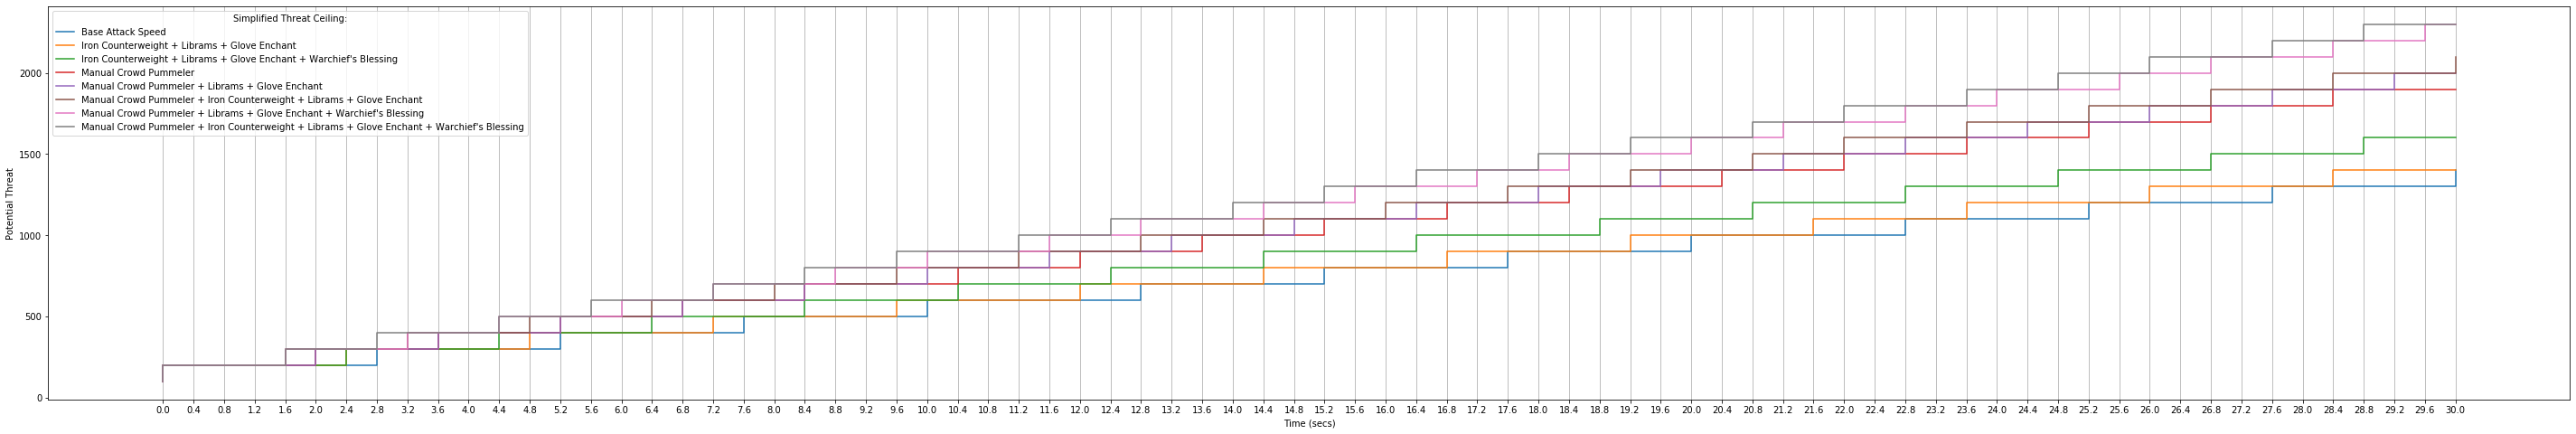

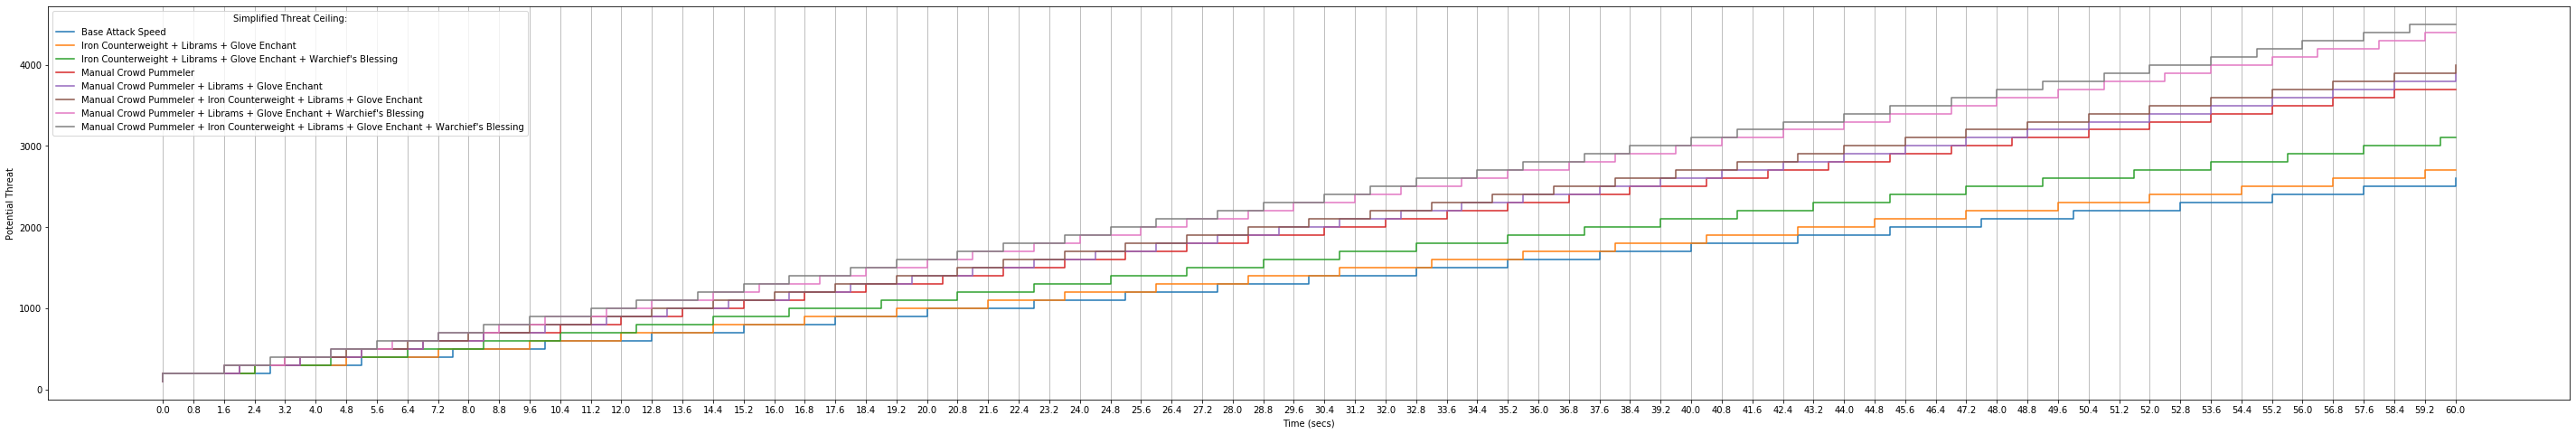

In [4]:
generatePlot(attackSpeedCombinations, 15)
generatePlot(attackSpeedCombinationsNoKiss, 30)
generatePlot(attackSpeedCombinationsNoKiss, 60)

# Differing Combat Start Times
The above plots assumed the first attack registered just before a spell batch. We can alter the time during the spell batch you get into range and register the first. Ultimately the effects are small and the times when your attacks land vary by at most a spell batch between any of the scnearios.
## Starting 100ms into a Spell Batch


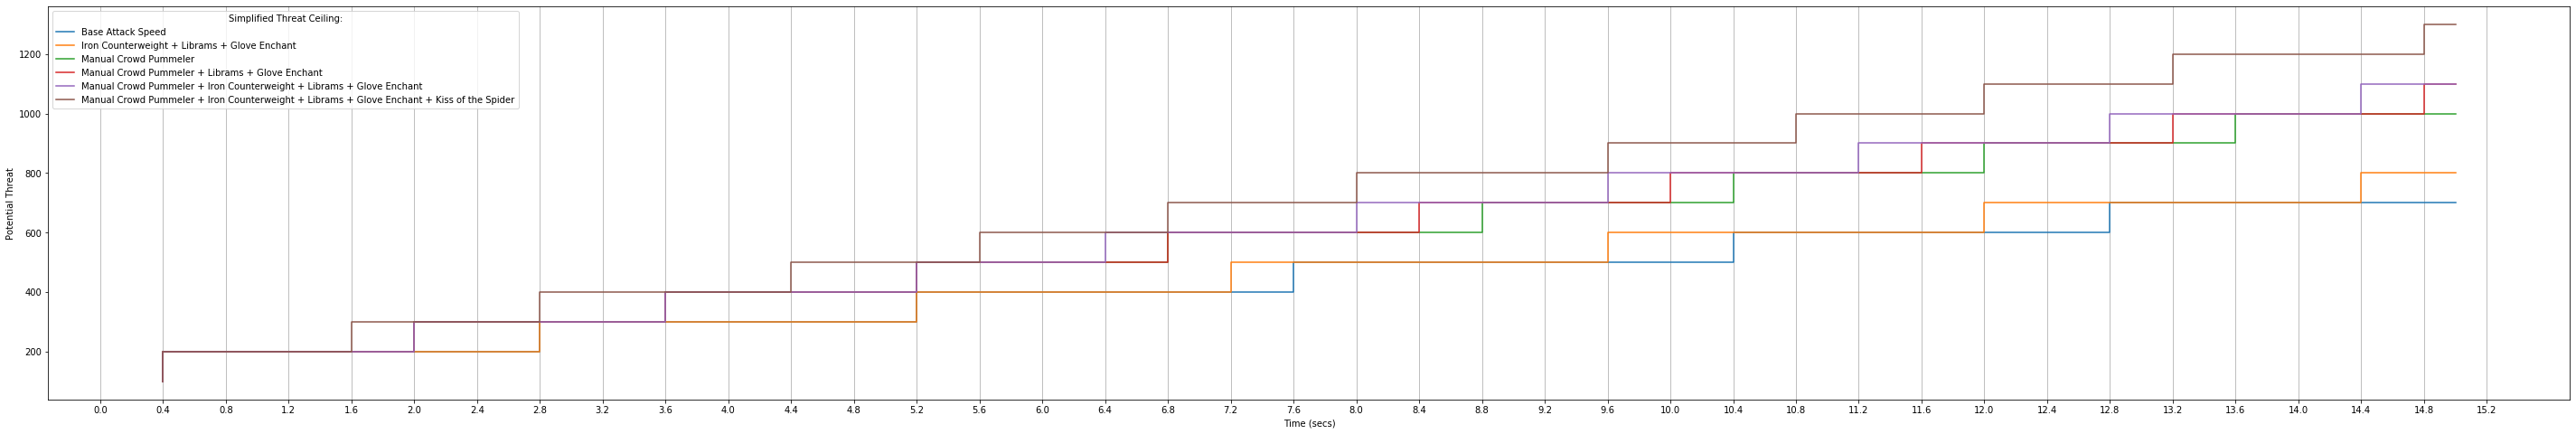

In [5]:
generatePlot(allianceOnlyAttackSpeedCombinations, 15,combatStartTime=0.1)

## Starting 200ms into a Spell Batch

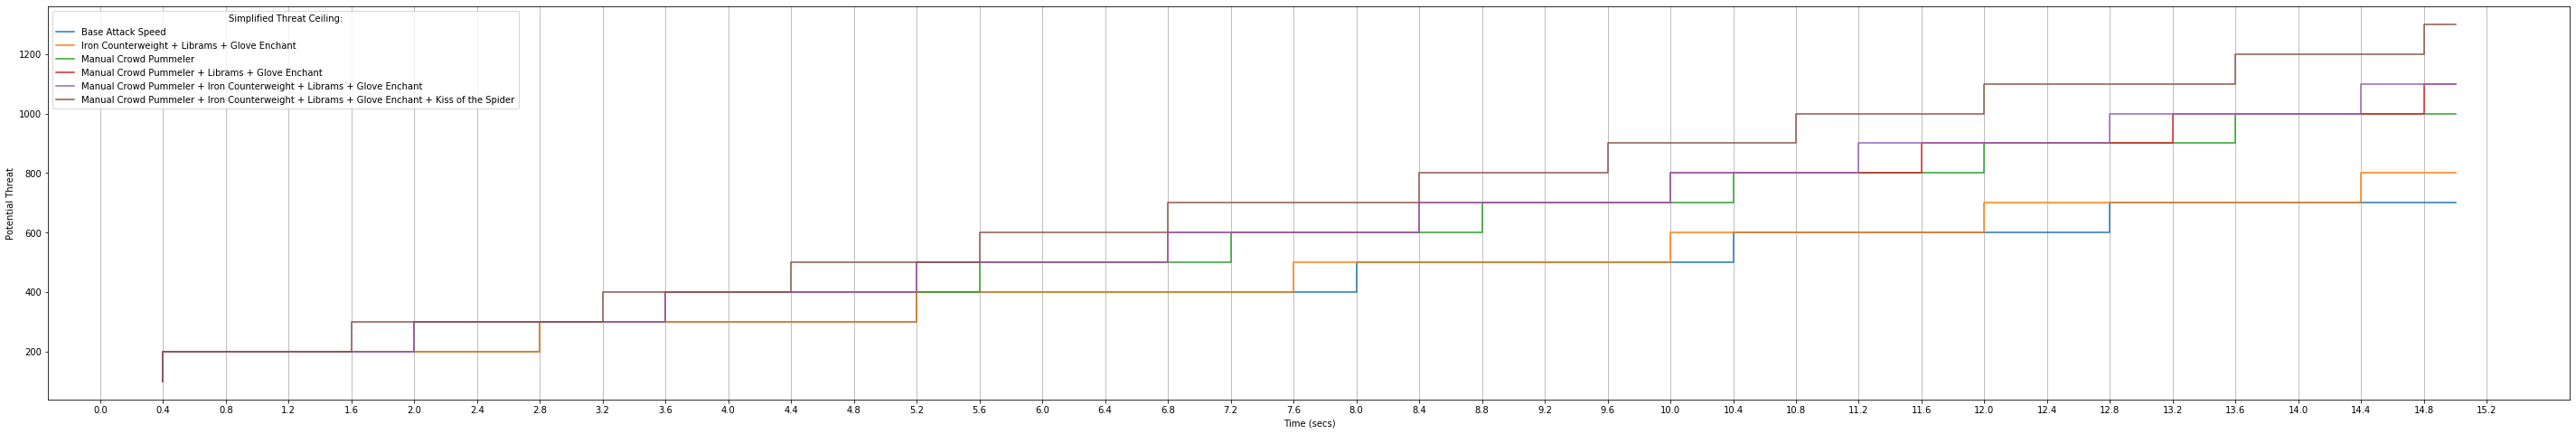

In [6]:
generatePlot(allianceOnlyAttackSpeedCombinations, 15,combatStartTime=0.2)

## Starting 300ms into a Spell Batch

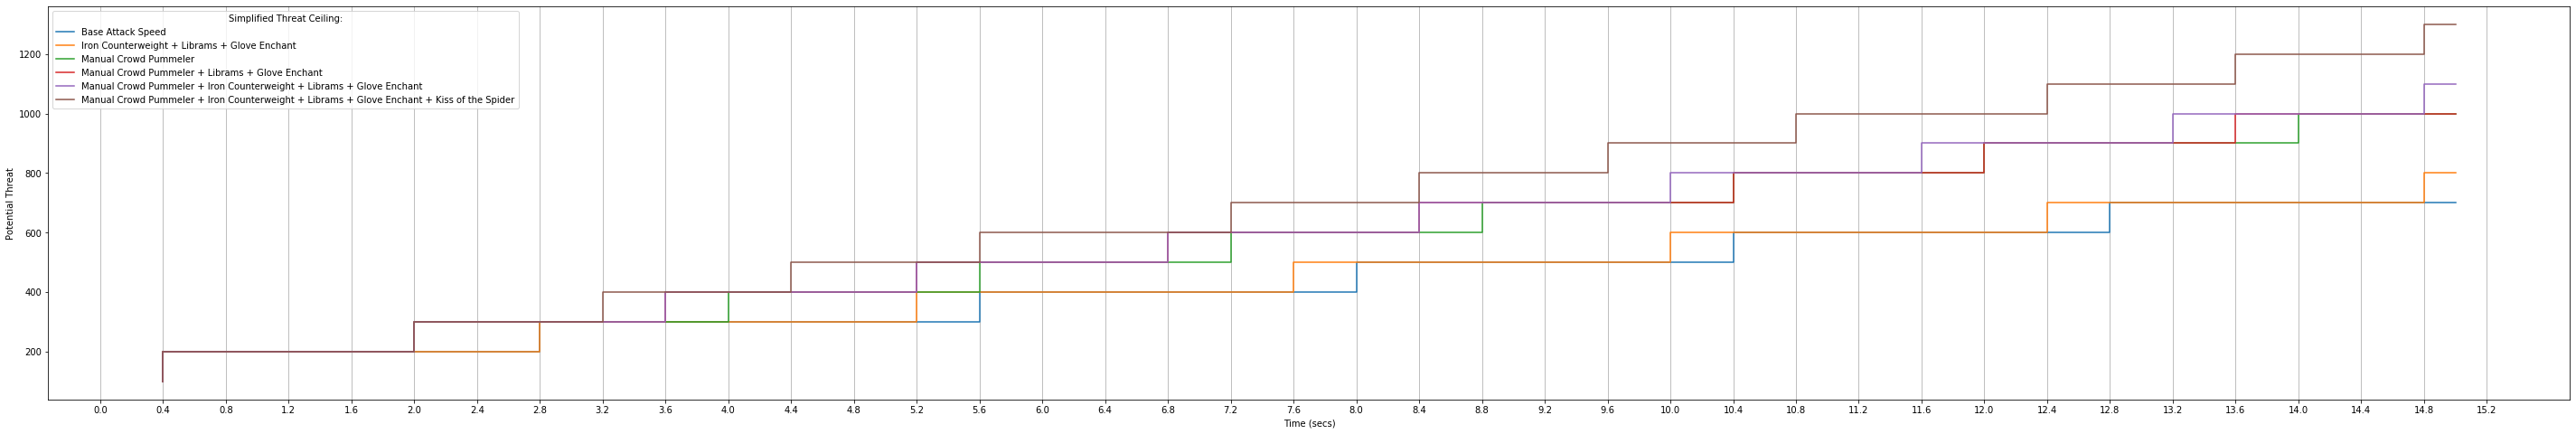

In [7]:
generatePlot(allianceOnlyAttackSpeedCombinations, 15,combatStartTime=0.3)

# Conclusions
From the plots we can conclude that attack speed does indeed increase threat generated and the effect becomes more pronounced over the duration of the fight. Does this mean that the attack speed enchants are better than the agility enchants? That cannot be answered from this analysis. What I can say is that your base attack speed is 2.5 and with a 6% attack speed buff (the Iron Counterweight and attack speed enchants) your attack speed is 2.3558. Given the spell batch interval in Classic is 400ms we have the following

In [8]:
deltaAttackSpeed = round(2.5 - 2.3558,4)
print(f'Attack Speed Difference:{deltaAttackSpeed}')
numberOfAttacksTillNextBatch = round(0.400 / deltaAttackSpeed,4)
print(f'Number of Attacks Until You Advance a Spell Batch:{numberOfAttacksTillNextBatch}')
print(f'Time elapsed till you advance a spell batch about {numberOfAttacksTillNextBatch* 2.3558} seconds')

Attack Speed Difference:0.1442
Number of Attacks Until You Advance a Spell Batch:2.7739
Time elapsed till you advance a spell batch about 6.534753619999999 seconds


Put simply, with the attack speed enchants about every 3 auto attacks (or 6.5 seconds) your attack comes out one spell batch sooner than a feral druid without the attack speed enchants. And this effect accumluates over time so after 6 auto attacks you attacks are coming out 2 spell batches sooner than another feral druid and after 9 auto attacks 3 spell batches sooner. 

Repeating this analysis for when you are using a Manual Crowd Pummeler yields

In [9]:
deltaAttackSpeed = round(1.6667 - 1.5705,4)
print(f'Attack Speed Difference:{deltaAttackSpeed}')
numberOfAttacksTillNextBatch = round(0.400 / deltaAttackSpeed,4)
print(f'Number of Attacks Until You Advance a Spell Batch:{numberOfAttacksTillNextBatch}')
print(f'Time elapsed till you advance a spell batch about {numberOfAttacksTillNextBatch* 1.5705} seconds')

Attack Speed Difference:0.0962
Number of Attacks Until You Advance a Spell Batch:4.158
Time elapsed till you advance a spell batch about 6.530139000000001 seconds


With a Manual Crowd Pummeler equiped and the attack speed enchants about every 4 autoattacks (or 6.5 seconds) your auto attacks come out one spell batch sooner than a feral druid without the attack speed enchants.

This accumulated buffer could what you need to allow DPS to go all out during the frenzy or execute phase of a boss encoutner and not worry about ripping threat off you. That said the agility enchants are not worthless and further analysis is needed to quantify the difference in performance of the two sets of enchants.